In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

LABEL_MAP = {"Airplane": 0, "Bicycle": 1, "Butterfly": 2, "Car": 3, "Flower": 4, "House": 5, "Ladybug": 6, "Train": 7, "Tree": 8, "Whale": 9}
REVERSE_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

Using cuda


In [104]:
# Download all data from S3 bucket
# !aws s3 sync s3://ai-pictionary-data C:\Users\nickj\Documents\Duke\Masters\AIPI540\ai-pictionary\data

In [2]:
class CustomImageFolderDataset(Dataset):
    def __init__(self, image_paths, extra_transforms=True):
        """
        Custom dataset for loading images from a folder structure.
        Applies a base transform for train, val, and test sets.
        Applies extra transforms for training/val when specified.
        """
        self.base_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
                            ])
        self.images = image_paths
        self.extra_transforms = extra_transforms
        self.label_map = {"Airplane": 0, "Bicycle": 1, "Butterfly": 2, "Car": 3, "Flower": 4, "House": 5, "Ladybug": 6, "Train": 7, "Tree": 8, "Whale": 9}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        
        images = []
        # Apply base transform
        images.append(self.base_transform(image))
        # Horizontal flip
        if self.extra_transforms:
            images.append(self.base_transform(transforms.functional.hflip(image)))
        # Random rotation
        if self.extra_transforms:
            rotation_transform = transforms.RandomRotation((-30,30), fill=(255, 255, 255))
            images.append(self.base_transform(rotation_transform(image)))
        # Random Translation
        if self.extra_transforms:
            translation_transform = transforms.RandomAffine(0, translate=(0.2, 0.2), scale=(0.6, 1.4), fill=(255, 255, 255))
            images.append(self.base_transform(translation_transform(image)))
        
        # Assuming the folder names represent the labels, extract label from the file path
        label = img_path.split(os.sep)[-2]
        label = self.label_map[label]
        
        return images, label

In [3]:
def custom_collate_fn(batch):
    """
    Custom collate function to combine multiple images into a single batch tensor.
    
    Args:
    - batch: List of tuples (images, label), where 'images' is a list of 4 transformed images.
    
    Returns:
    - images_tensor: A tensor containing all images stacked together.
    - labels_tensor: A tensor containing all labels, repeated for each image transformation.
    """
    images_list = []
    labels_list = []
    for images, label in batch:
        # Stack all 4 images together, adding an extra dimension for 'stacking'
        images_stack = torch.stack(images, dim=0)
        images_list.append(images_stack)
        
        # Repeat the label 4 times to match the number of images
        labels_list.extend([label] * len(images))
    
    # Concatenate all images and labels from the batch together
    images_tensor = torch.cat(images_list, dim=0)
    labels_tensor = torch.tensor(labels_list)
    
    return images_tensor, labels_tensor

In [4]:
# Initialize your custom dataset
ROOT_DIR = 'C:\\Users\\nickj\\Documents\\Duke\\Masters\\AIPI540\\ai-pictionary\\data'
all_image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(ROOT_DIR) for f in filenames if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg']]
custom_dataset = CustomImageFolderDataset(all_image_paths, extra_transforms=True)

# Create a DataLoader
example_loader = DataLoader(custom_dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=custom_collate_fn)

Image 1 Label: Bicycle
Image 2 Label: Whale


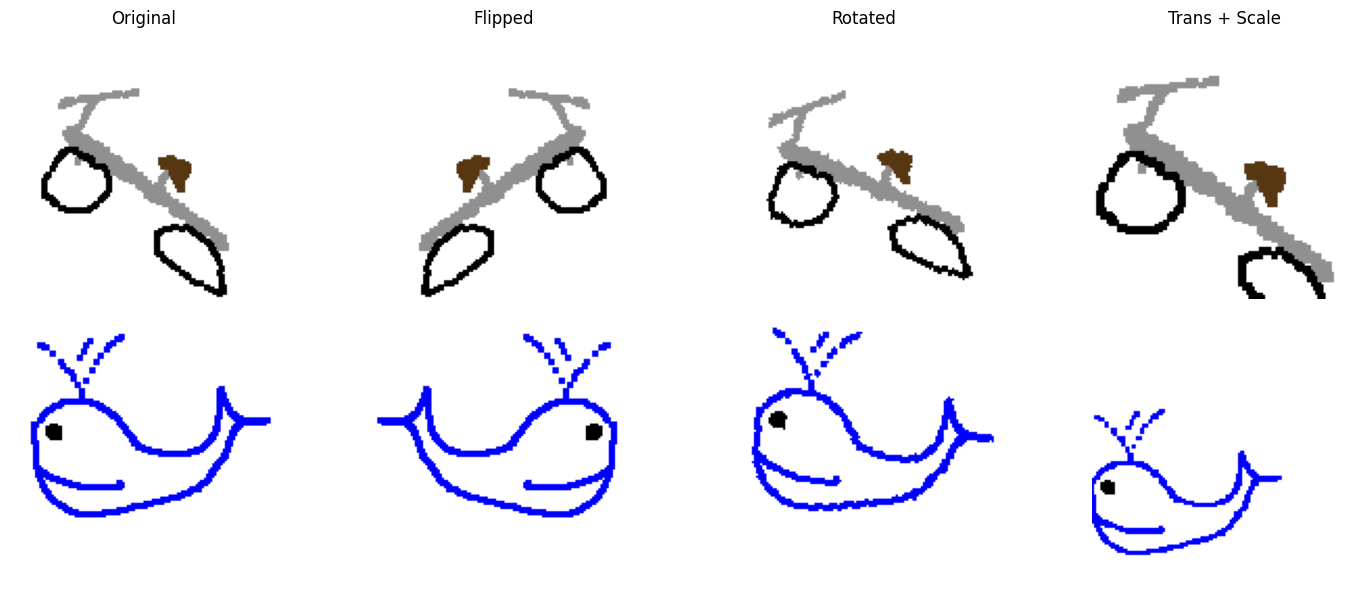

In [7]:
for images, labels in example_loader:
    transformations = 4  # Original, Flipped, Rotated, Translation + Scaling
    
    # Unnormalize the images for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    images_unnorm = images * std + mean
    images_unnorm = images_unnorm.clip(0, 1) 
    
    # Determine the number of rows needed for subplot (assuming 4 transformations per image)
    num_rows = len(images) // transformations
    plt.figure(figsize=(15, num_rows * 3)) 
    
    # Display images
    for i in range(len(images)):
        plt.subplot(num_rows, transformations, i + 1)
        img_np = images_unnorm[i].permute(1, 2, 0).numpy()  
        plt.imshow(img_np)
        plt.axis('off')
        
        # Add titles to the first row of images to denote the transformation
        if i < transformations:
            titles = ['Original', 'Flipped', 'Rotated', 'Trans + Scale']
            plt.title(titles[i % transformations])
    
    # Print labels for the entire batch; adjust printing if necessary for your label format
    # This assumes labels are repeated for each transformation of the same image
    unique_labels = labels[::transformations] 
    for idx, label in enumerate(unique_labels):
        print(f"Image {idx+1} Label: {REVERSE_LABEL_MAP[label.item()]}")
    
    plt.tight_layout()
    plt.show()
    break

## Transfer Learning with ResNet50 for Image Classification

In [15]:
# Load in pre-trained model
model = models.resnet50(weights="DEFAULT")
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Add on custom classifier
from collections import OrderedDict
classifier = torch.nn.Sequential(OrderedDict([
    ('fc1', torch.nn.Linear(2048, 512)),
    ('relu', torch.nn.ReLU()),
    ('fc2', torch.nn.Linear(512, 10)),
    ('output', torch.nn.Softmax(dim=1))
]))

model.fc = classifier
model = model.to(device)

In [16]:
# Setup training loop

def train(model, criterion, optimizer, train_loader, val_loader, epochs=10, device='cpu'):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch+1} Training Loss: {train_loss}")

        # Validation
        model.eval()
        val_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                val_loss += loss.item()

                ps = torch.exp(output)
                _, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        val_loss = val_loss / len(val_loader)
        accuracy = accuracy / len(val_loader)
        print(f"Epoch {epoch+1} Validation Loss: {val_loss} Accuracy: {accuracy}")

In [17]:
# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Define train, val, and test image paths. Then create a train and val datalaoders
all_image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(ROOT_DIR) for f in filenames if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg']]
train_image_paths, test_image_paths = train_test_split(all_image_paths, test_size=0.1)
train_image_paths, val_image_paths = train_test_split(train_image_paths, test_size=0.1)

train_dataset = CustomImageFolderDataset(train_image_paths, extra_transforms=True)
val_dataset = CustomImageFolderDataset(val_image_paths, extra_transforms=True)
test_dataset = CustomImageFolderDataset(test_image_paths, extra_transforms=False)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

# Train the model
train(model, criterion, optimizer, train_loader, val_loader, epochs=10, device=device)



Epoch 1 Training Loss: 2.0521038183267564
Epoch 1 Validation Loss: 1.8255922698205518 Accuracy: 0.6733870967741935
Epoch 2 Training Loss: 1.8185941758363142
Epoch 2 Validation Loss: 1.7693563276721584 Accuracy: 0.7137096774193549
Epoch 3 Training Loss: 1.7415675356768179
Epoch 3 Validation Loss: 1.6985397473458321 Accuracy: 0.7701612903225806
Epoch 4 Training Loss: 1.7146503303361975
Epoch 4 Validation Loss: 1.6933975065908125 Accuracy: 0.7943548387096774
Epoch 5 Training Loss: 1.693735160689423
Epoch 5 Validation Loss: 1.6932409059616826 Accuracy: 0.7701612903225806
Epoch 6 Training Loss: 1.65903373559316
Epoch 6 Validation Loss: 1.7017416127266423 Accuracy: 0.7741935483870968
Epoch 7 Training Loss: 1.654267254083053
Epoch 7 Validation Loss: 1.6434080312328954 Accuracy: 0.8387096774193549
Epoch 8 Training Loss: 1.6507956636124763
Epoch 8 Validation Loss: 1.692031902651633 Accuracy: 0.7782258064516129
Epoch 9 Training Loss: 1.6575050388557324
Epoch 9 Validation Loss: 1.6904196296968768

In [18]:
# Test the model
model.eval()
test_loss = 0
accuracy = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        test_loss += loss.item()

        ps = torch.exp(output)
        _, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

In [20]:
print(f"Test Loss: {test_loss / len(test_loader)} Accuracy: {accuracy / len(test_loader)}")

Test Loss: 1.657889022546656 Accuracy: 0.8235294117647058


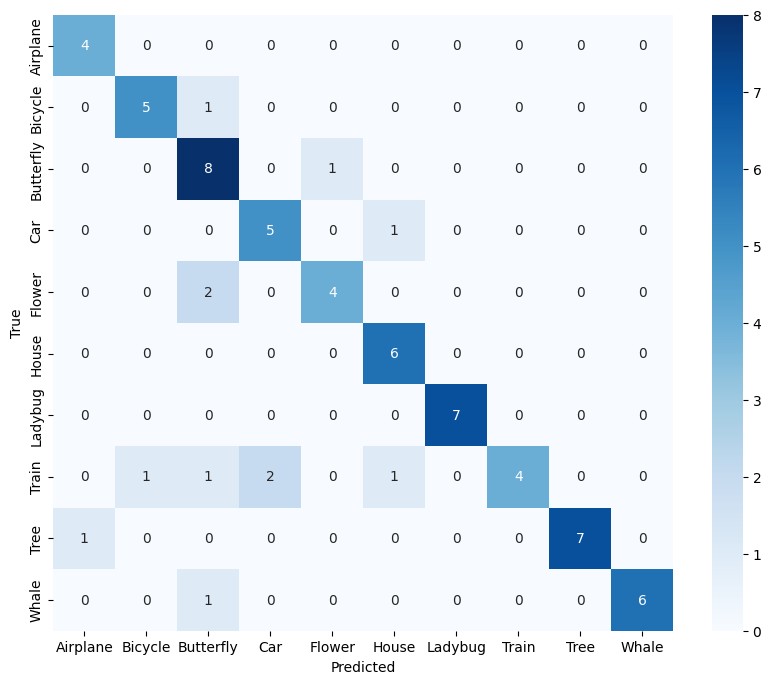

In [21]:
# Make a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        ps = torch.exp(output)
        _, top_class = ps.topk(1, dim=1)
        y_true.append(labels.item())
        y_pred.append(top_class.item())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

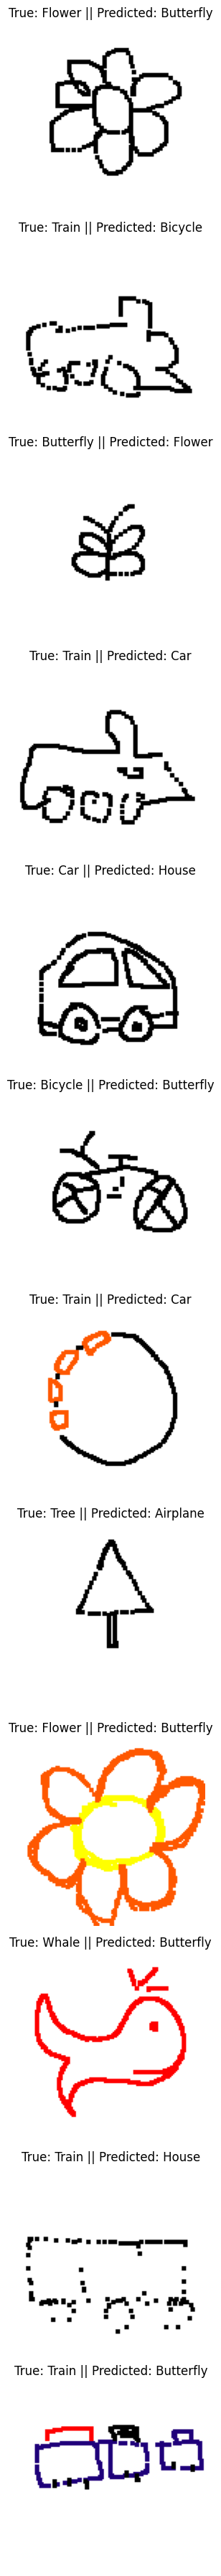

In [23]:
# Show the images that were misclassified
model.eval()
misclassified_images = []
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        ps = torch.exp(output)
        _, top_class = ps.topk(1, dim=1)
        if top_class != labels:
            misclassified_images.append(images)
            y_true.append(labels.item())
            y_pred.append(top_class.item())

# Display the misclassified images
num_rows = len(misclassified_images)
plt.figure(figsize=(15, num_rows * 3))
for i, image in enumerate(misclassified_images):
    plt.subplot(num_rows, 1, i + 1)
    img_np = image[0].permute(1, 2, 0).cpu().numpy()
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(f"True: {REVERSE_LABEL_MAP[y_true[i]]} || Predicted: {REVERSE_LABEL_MAP[y_pred[i]]}")

plt.tight_layout()
plt.show()

In [24]:
# Save model
torch.save(model.state_dict(), '../../saved_models/model_0.pth')